In [1]:
# loading the data
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
from scipy import misc
import csv
import numpy as np
from scipy import misc

CAR_DIR = './vehicles/'
NON_CAR_DIR = './non-vehicles/'
W = 32
H = 32
def load_examples(dir):
    examples = []
    for subdir in listdir(dir):
        try:
            for f_name in listdir(dir + subdir):
                try:
                    img = misc.imread(dir + subdir + '/' + f_name)
                    img = misc.imresize(img, (H,W,3))
                    #if img.shape != (64, 64, 3) : print ("AAAAAAAA")
                    examples.append(img)
                except IOError: pass
        except NotADirectoryError: pass
    return examples

car_img = load_examples(CAR_DIR)
non_car_img = load_examples(NON_CAR_DIR)

print ("Car examples: ", len(car_img))
print ("Non-Car examples: ", len(non_car_img))




Car examples:  8792
Non-Car examples:  8968


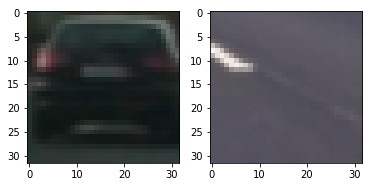

In [2]:
%matplotlib inline
plt.subplot(1,2,1)
plt.imshow(car_img[600])
plt.subplot(1,2,2)
plt.imshow(non_car_img[600])

(32, 32, 3) (324,)


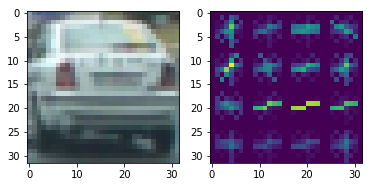

In [3]:
# getting the features
from skimage.feature import hog
import cv2

def hog_features(img):
    return hog(img, visualise=True)

def features_from_img(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)[:,:,1]
    vec = hog(img, visualise=False)
    return vec

img = car_img[2701]
vec, hogs = hog_features(cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,1])
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(hogs)

print (car_img[0].shape, features_from_img(car_img[0]).shape)

8792 8968
X_train: 15096
X_test: 2664
y_train: 15096
y_test: 2664


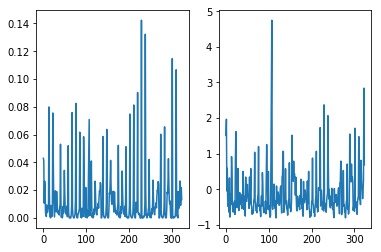

In [4]:
# building the training sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

car_features = [features_from_img(img) for img in car_img]
non_car_features = [features_from_img(img) for img in non_car_img]
features = car_features + non_car_features

# before standardization
plt.subplot(1,2,1)
plt.plot(features[10])

# after the standardization
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)
plt.subplot(1,2,2)
plt.plot(features[10])

labels = [1 for i in range(len(car_features))] + [0 for i in range(len(non_car_features))]
print (len(car_features), len(non_car_features))


X_train, X_test, y_train, y_test =  train_test_split(features, labels, test_size=0.15, random_state=999)

print('X_train:' , len(X_train))
print('X_test:' , len(X_test))
print('y_train:' , len(y_train))
print('y_test:' , len(y_test))

In [5]:
import time
t = time.time()

n = len(X_train)
# training
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train[:n],y_train[:n])
print("Time:", time.time() - t)

Time: 18.068676948547363


In [6]:
print(clf.score(X_train[:n], y_train[:n]))
#print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.989334923158
0.97484984985


(720, 1280, 3)


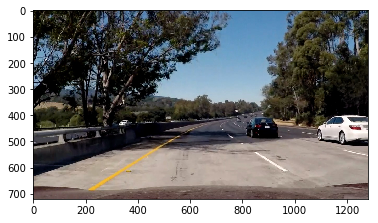

In [7]:
#loading the test data
TEST_DIR = './test_images/'
test_frames = []
for f_name in listdir(TEST_DIR):
    try:
        test_frames.append(misc.imread(TEST_DIR + f_name))
    except OSError: pass

print(test_frames[0].shape)
plt.imshow(test_frames[4])

In [8]:
from scipy.ndimage import label
def get_squares(d):
    arr = np.zeros(d.shape)
    arr[d!=0] = 1
        
    labeled, features = label(arr)
    
    boxes = []
    for i in range(1, features+1):
        y_coords, x_coords = np.where(labeled == i)
        boxes.append((np.min(y_coords), np.min(x_coords), np.max(y_coords), np.max(x_coords)))
        
    return boxes
            

                     
            

t = np.array([[0,1,0,0,0,0],
              [1,3,1,0,0,0],
              [0,1,0,0,0,0],
              [0,0,0,0,0,0],
              [0,0,0,1,1,1],
              [0,0,0,0,1,1]]
              )

get_squares(t)

[(0, 0, 2, 2), (4, 3, 5, 5)]

In [24]:
# the sliding logic
def get_boxes(shape=(720, 1280), box_size=100, step=0.5 , top_crop=400, bottom_crop=200, left_crop=300, right_crop=0):
    box_list = []
    y = top_crop
    while y < shape[0] - bottom_crop:
        x = left_crop
        while x < shape[1] - right_crop:
            box_list.append((y, x, y + box_size, x + box_size))
            x += int(box_size * step)
        y += int(box_size * step)
    return box_list

from skimage import draw


heat_map = []

def process_frame(image, threshold = 40):
    img = np.copy(image)
    
    chunk_coords = []
    #chunk_coords += get_boxes(box_size=70, step=0.3)
    chunk_coords += get_boxes(box_size=100, step=0.2, top_crop = 400, left_crop=500)
    chunk_coords += get_boxes(box_size=150, step=0.2, top_crop = 450, left_crop=500)
    chunk_coords += get_boxes(box_size=200, step=0.3, top_crop=500, left_crop=500)

    
    chunks = []
    for y1, x1, y2, x2 in chunk_coords:
        chunk = misc.imresize(img[y1:y2, x1:x2], (H,W))
        chunks.append(chunk)
    
    preds = clf.predict(scaler.transform([features_from_img(ch) for ch in chunks]))    
    matching_indices = [i for i,x in enumerate(preds) if x == 1]

    heat_frame = np.zeros((img.shape[0], img.shape[1]))
        
    for i in matching_indices:
        y1, x1, y2, x2 = chunk_coords[i]
        heat_frame[y1:y2, x1:x2] += 1
        img[y1:y2, x1:x2,:2] = 100
        
    #return img

    
    # heat from for the frame
    heat_map.append(heat_frame) 
    
    # the aggregated heat frame data
    hf = np.sum(heat_map[-15:], axis=0)
    hf[hf < threshold] = 0

    final = np.copy(image)
    for y1, x1, y2, x2 in get_squares(hf):
        final[y1:y2,x1:x2,0] = 100

    return final



In [ ]:
img = np.copy(test_frames[0])
plt.figure(figsize=(20,20))
plt.imshow(process_frame(img))

#plt.imshow(process_frame(img))

In [22]:
from moviepy.editor import VideoFileClip

def write_video(input_f, output_f, f):
    clip = VideoFileClip(input_f)#.subclip(30,40)
    transformed = clip.fl_image(f)
    transformed.write_videofile(output_f, audio=False)

#INPUT_VIDEO = './test_video.mp4'
INPUT_VIDEO = './project_video.mp4'

write_video(INPUT_VIDEO, './output_video1.mp4', process_frame)


[MoviePy] >>>> Building video ./output_video1.mp4
[MoviePy] Writing video ./output_video1.mp4


100%|█████████▉| 1260/1261 [16:23<00:00,  1.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video1.mp4 

